In [1]:
import torch
import torch.nn as nn  # 신경망 모듈, 구축 및 훈련에 사용
from torch.utils.data.dataset import Dataset # 사용자 정의 데이터 셋을 만들어 딥러닝을 할 수 있게 함
import torchvision.transforms as T # 이미지 전처리에 필요한 transform 사용
from torch.utils.data import DataLoader # 데이터 관리에 필요한 dataloader
import torch.nn.functional as F # loss or cost gradient와 같은 여러 함수를 사용할 수 있음
from sklearn.metrics import f1_score, confusion_matrix # f1 score와 행렬을 계산 -> 모델의 성능 평가
import pandas as pd # pandas를 사용한 데이터 조작 및 분석
import numpy as np # numpy 사용
import matplotlib.pyplot as plt #시각화를 위한 차트 사용
from matplotlib import pyplot as plt
import seaborn as sns
!pip install torchinfo
from torchinfo import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

fer2013_dataset_file_path = '/content/drive/MyDrive/Colab Notebooks/fer2013.csv'

In [4]:
# 7개 감정을 각 요소로 가지는 클래스 레이블 정의
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
NUM_CLASSES = len(CLASS_LABELS) # 변수에 7개 저장
#dictionary -> Class index, label을 각각 연결하여서 매핑정보를 형성하는데 유용
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

In [5]:
df = pd.read_csv(fer2013_dataset_file_path) #pandas를 사용하여 csv에서 데이터를 읽음 -> 데이터프레임으로 변환
df #데이터프레임에서 반환

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


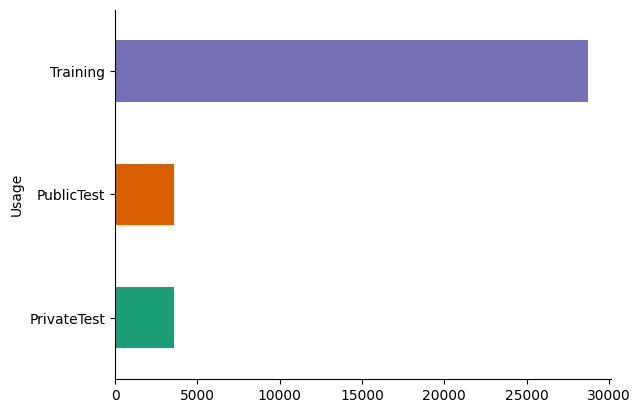

In [6]:
df.groupby('Usage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

df.groupby('Usage').size(): 'Usage' 열을 기준으로 데이터프레임을 그룹화하고, 각 그룹의 크기(빈도)를 계산합니다.

.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2')): 그룹화된 크기를 수평 막대 그래프로 시각화합니다. kind='barh'는 수평 막대 그래프를 생성하라는 옵션이며, color=sns.palettes.mpl_palette('Dark2')는 Seaborn 팔레트에서 'Dark2' 색상을 사용하여 막대의 색을 지정합니다.


plt.gca().spines[['top', 'right',]].set_visible(False): 그래프의 상단과 오른쪽 테두리를 제거합니다. plt.gca()는 현재 축(axes)을 가져오는 함수이고, spines[['top', 'right',]].set_visible(False)는 상단과 오른쪽 테두리를 숨김 처리합니다.

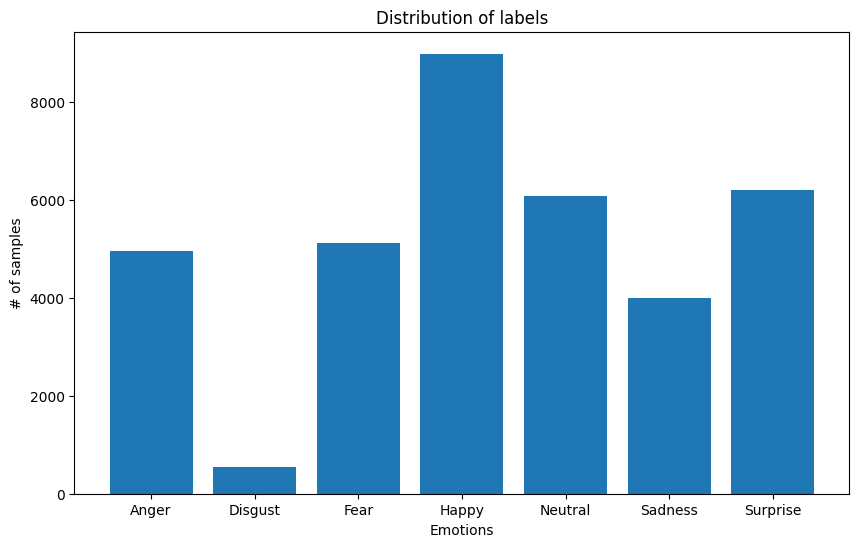

In [7]:
plt.figure(figsize=(10,6))
plt.bar(CLASS_LABELS, [df['emotion'].tolist().count(i) for i in np.arange(NUM_CLASSES)])
plt.xlabel('Emotions')
plt.ylabel('# of samples')
plt.title('Distribution of labels')
plt.show()

## 각 클래스 레이블에 해당하는 샘플의 분포를 차트로 시각화

Train set shape: [28709, 1, 48, 48], labels shape: [28709]
Validation set shape: [3589, 1, 48, 48], labels shape: [3589]
Test set shape: [3589, 1, 48, 48], labels shape: [3589]


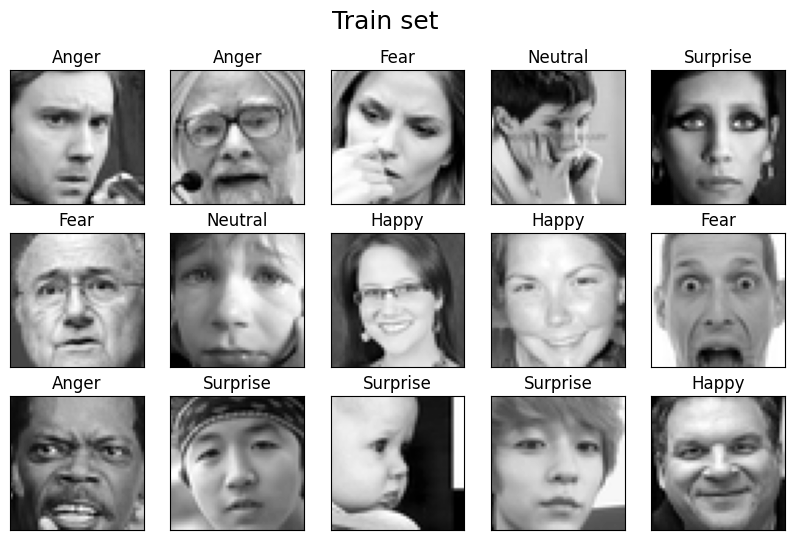

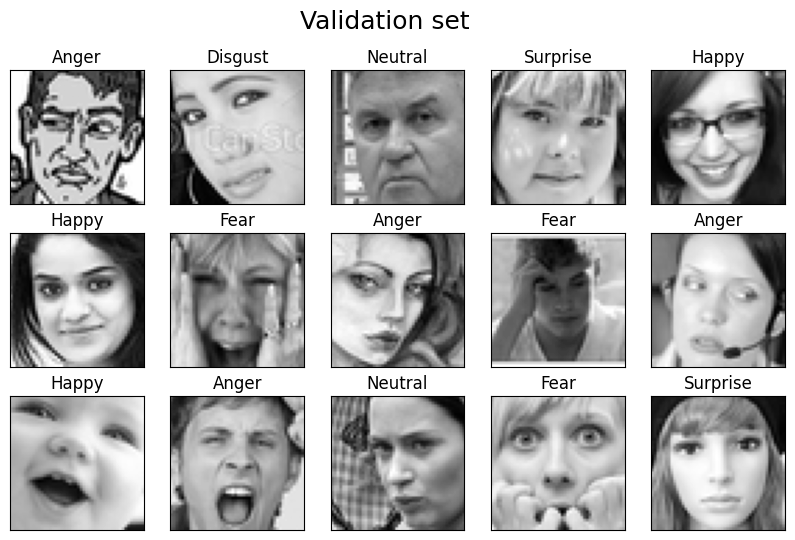

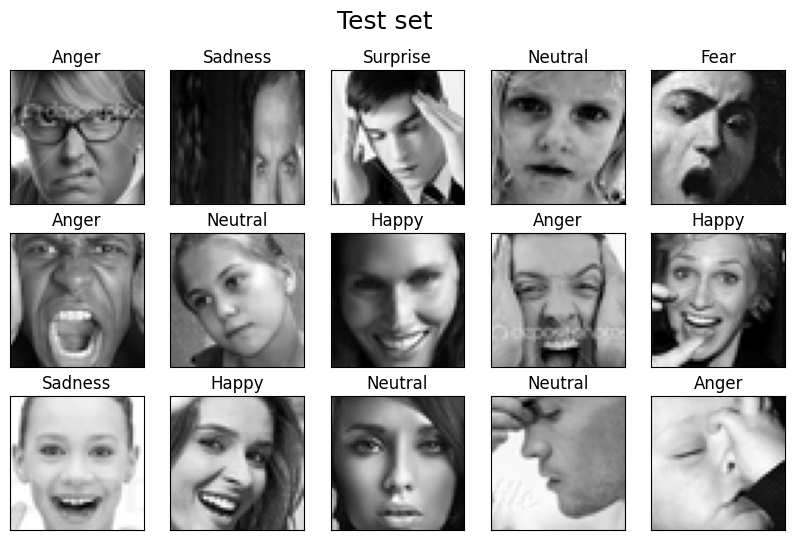

In [8]:
pixels = df['pixels'] # pixels 열을 선택 후 변수 pixels에 저장
pixels = pixels.apply(lambda x: x.split(" ")).tolist() #각 이미지의 픽셀 값을 공백으로 분리, 리스트 변환
pixels = np.uint8(pixels) # 픽셀 값을 정수로 변환
pixels = torch.Tensor(pixels) # Numpy -> Tensor
pixels = torch.reshape(pixels, (pixels.shape[0], 1, 48, 48)) # 이미지 개수, 채널 수, 높이, 너비로 조정 1채널, 48X48
train_idx = df.index[df['Usage'] == 'Training'].tolist() # Usage 열이 Trainning인 행의 인덱스
val_idx   = df.index[df['Usage'] == 'PublicTest'].tolist() # PublicTest 인덱스
test_idx  = df.index[df['Usage'] == 'PrivateTest'].tolist() # Private Test 인덱스를 가져온다

X_train = pixels[train_idx]
y_train = torch.Tensor(df.iloc[train_idx]['emotion'].tolist())
X_val = pixels[val_idx]
y_val = torch.Tensor(df.iloc[val_idx]['emotion'].tolist())
X_test = pixels[test_idx]
y_test = torch.Tensor(df.iloc[test_idx]['emotion'].tolist())
print(f'Train set shape: {list(X_train.shape)}, labels shape: {list(y_train.shape)}')
print(f'Validation set shape: {list(X_val.shape)}, labels shape: {list(y_val.shape)}')
print(f'Test set shape: {list(X_test.shape)}, labels shape: {list(y_test.shape)}')

# 레이블 모양 출력
# 각각 데이터셋들 사진 확인

# Train set
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_train[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_train[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Train set', fontsize=18)
plt.show()

# Validation set
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_val[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_val[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Validation set', fontsize=18)
plt.show()

# Test set
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_test[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_test[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Test set', fontsize=18)
plt.show()

In [9]:
class tensorDataset(Dataset):

    def __init__(self, images, labels, train: bool):
        self.images = images / 255
        self.labels = labels
        self.train = train
        self.image_transform = T.Compose([
            T.ToPILImage(),
            T.RandomHorizontalFlip(p=0.3),
            T.RandomVerticalFlip(p=0.3),
            T.RandomRotation(degrees=(-20, 20)),
            T.ToTensor()
        ])

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        if self.train:
            img = self.image_transform(img)

        img = img.detach().clone().requires_grad_(True)

        return img, label

    def __len__(self):
        return len(self.images)

In [10]:
# 각 데이터셋들에 대한 Tensor 형태 데이터넷 생성 + Dataloader 생성, 배치 크기에 따른 미니배치 적용

def create_dataloaders(batch_size, X_train, y_train, X_val, y_val, X_test=None, y_test=None):

    train_dataset = tensorDataset(X_train, y_train, train=True)
    val_dataset   = tensorDataset(X_val, y_val, train=False)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

    if X_test is not None:
        test_dataset  = tensorDataset(X_test, y_test, train=False)
        test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
        return train_dataloader, val_dataloader, test_dataloader

    return train_dataloader, val_dataloader

In [11]:
class ED_model(nn.Module): #default CNN Model
    def __init__(self, in_channels=1, out_channels=7):
        super(ED_model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(p=0.3)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(p=0.3)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 48x48 -> 24x24
        self.dropout3 = nn.Dropout(p=0.3)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(p=0.3)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        self.dropout5 = nn.Dropout(p=0.3)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn6 = nn.BatchNorm2d(128)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 24x24 -> 12x12
        self.dropout6 = nn.Dropout(p=0.3)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn7 = nn.BatchNorm2d(64)
        self.dropout7 = nn.Dropout(p=0.3)

        self.conv8 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn8 = nn.BatchNorm2d(16)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 12x12 -> 6x6
        self.dropout8 = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(in_features=6*6*16, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=32)
        self.fc3 = nn.Linear(32, out_channels)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x) # <- block 1
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x) # <- block 2
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.dropout3(x) # <- block 3

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x) # <- block 4
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout5(x) # <- block 5
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = self.dropout6(x) # <- block 6

        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x) # <- block 7
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.max_pool3(x)
        x = self.dropout8(x) # <- block 8

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)

        return x

Convolutional Layers (conv1 to conv8): 각 합성곱 층은 이미지의 다양한 특징을 추출합니다. kernel_size=3은 3x3 크기의 필터를 사용하고, padding='same'은 출력 크기를 입력과 동일하게 유지하도록 패딩을 적용합니다.

Batch Normalization (bn1 to bn8): 각 합성곱 층의 출력에 배치 정규화를 적용하여 안정적인 학습을 돕습니다.

Dropout (dropout1 to dropout8): 과적합을 방지하기 위해 각 합성곱 층의 출력에 드롭아웃을 적용합니다.

Max Pooling (max_pool1 to max_pool3): 최대 풀링을 사용하여 이미지의 공간 해상도를 줄입니다.

Fully Connected Layers (fc1 to fc3): 전체적인 이미지 정보를 사용하여 최종적인 예측을 수행하는 완전 연결 층입니다.

Activation Function (ReLU): 각 합성곱 층의 출력에는 ReLU(Rectified Linear Unit) 활성화 함수가 적용되었습니다.

Softmax Activation (output layer): 모델의 출력층에서는 소프트맥스 활성화 함수를 사용하여 다중 클래스 분류를 위한 확률 분포를 생성합니다.

In [12]:
model = ED_model(in_channels=1, out_channels=NUM_CLASSES)
summary(model, input_size=(99, 1, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
ED_model                                 [99, 7]                   --
├─Conv2d: 1-1                            [99, 16, 48, 48]          144
├─BatchNorm2d: 1-2                       [99, 16, 48, 48]          32
├─Dropout: 1-3                           [99, 16, 48, 48]          --
├─Conv2d: 1-4                            [99, 64, 48, 48]          9,216
├─BatchNorm2d: 1-5                       [99, 64, 48, 48]          128
├─Dropout: 1-6                           [99, 64, 48, 48]          --
├─Conv2d: 1-7                            [99, 128, 48, 48]         73,728
├─BatchNorm2d: 1-8                       [99, 128, 48, 48]         256
├─MaxPool2d: 1-9                         [99, 128, 24, 24]         --
├─Dropout: 1-10                          [99, 128, 24, 24]         --
├─Conv2d: 1-11                           [99, 128, 24, 24]         147,456
├─BatchNorm2d: 1-12                      [99, 128, 24, 24]         256

In [13]:
def train():

    for epoch in range(1, EPOCHS+1):

        # Train model
        model.train()
        train_losses   = []
        train_accuracy = []
        train_f1       = []

        for i, batch in enumerate(train_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Train model
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 7, H, W]
            loss   = criterion(output, label_batch)
            loss.backward()
            optimizer.step()

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            train_losses.append(loss.item())
            train_accuracy.append(acc.cpu())
            train_f1.append(f1)
            # print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}, learning rate: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        total_train_losses.append(np.mean(train_losses))
        total_train_accuracy.append(np.mean(train_accuracy))
        total_train_f1.append(np.mean(train_f1))

        #Update learning rate
        learning_rate_tracker.append(optimizer.state_dict()['param_groups'][0]['lr'])
        scheduler.step()

        # Validate model
        model.eval()
        val_losses   = []
        val_accuracy = []
        val_f1       = []

        for i, batch in enumerate(val_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Validate model
            with torch.cuda.amp.autocast():
                output = model(img_batch)
                loss   = criterion(output, label_batch)

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            val_losses.append(loss.item())
            val_accuracy.append(acc.cpu())
            val_f1.append(f1)
            # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
        print('-'*106)
        total_val_losses.append(np.mean(val_losses))
        total_val_accuracy.append(np.mean(val_accuracy))
        total_val_f1.append(np.mean(val_f1))


        # Save the results so far
        temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
        temp_df.to_csv('train_val_measures')

In [14]:
# HYPERPARAMETERS for training run
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 60
LR = 0.01
BATCH_SIZE = 256

model = ED_model(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE, X_train, y_train, X_val, y_val, X_test, y_test)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # Use dynamic learning rate
criterion = nn.CrossEntropyLoss().to(DEVICE)

total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []
learning_rate_tracker = []

In [15]:
train()

TRAIN       Epoch: 1 | Epoch metrics | loss: 1.9011, f1: 0.063, accuracy: 0.250, learning rate: 0.010000
VALIDATION  Epoch: 1 | Epoch metrics | loss: 1.8934, f1: 0.082, accuracy: 0.255
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 1.8860, f1: 0.086, accuracy: 0.259, learning rate: 0.010000
VALIDATION  Epoch: 2 | Epoch metrics | loss: 1.8774, f1: 0.111, accuracy: 0.265
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 1.8714, f1: 0.127, accuracy: 0.270, learning rate: 0.010000
VALIDATION  Epoch: 3 | Epoch metrics | loss: 1.8537, f1: 0.162, accuracy: 0.301
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 1.8559, f1: 0.151, accuracy: 0.286, learning rate: 0.010000
VALIDATION  Epoch: 

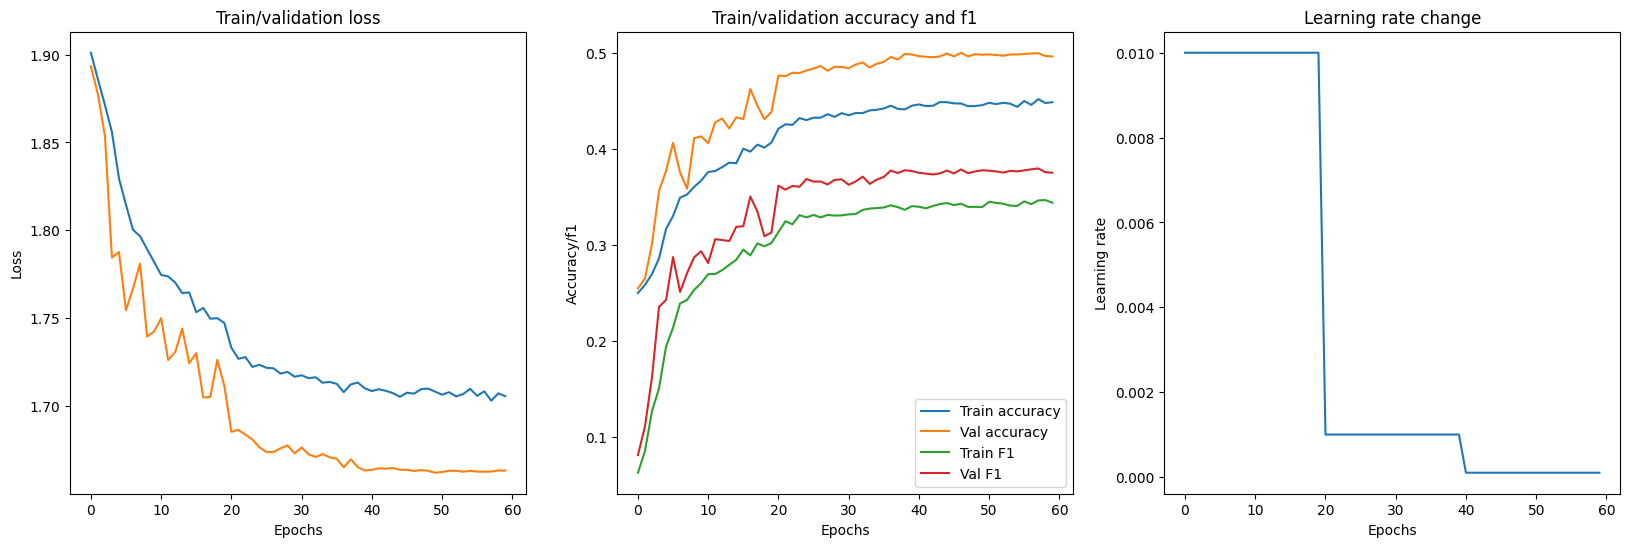

In [16]:
f, axarr = plt.subplots(1,3, figsize = (20,6))
axarr[0].plot(list(range(len(total_train_losses))), total_train_losses)
axarr[0].plot(list(range(len(total_train_losses))), total_val_losses)
axarr[0].set_title('Train/validation loss')
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[1].plot(list(range(len(total_train_accuracy))), total_train_accuracy, label='Train accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_accuracy, label='Val accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_train_f1, label='Train F1')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_f1, label='Val F1')
axarr[1].set_title('Train/validation accuracy and f1')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy/f1')
axarr[1].legend()

axarr[2].plot(np.arange(len(learning_rate_tracker)), learning_rate_tracker)
axarr[2].set_title('Learning rate change')
axarr[2].set_xlabel('Epochs')
axarr[2].set_ylabel('Learning rate')
plt.show()